In [1]:
import pandas as pd
import numpy as np
import os
from datetime import timedelta
import matplotlib.pyplot as plt

## Compute Average Duration of Stress and Recovery Periods

### Virtual Subjects

In [2]:
# define directories
dir_data_v = 'data_virtual'
dir_hr_v = os.path.join(dir_data_v, 'parsed_emotibit_data')
dir_resp_v = os.path.join(dir_data_v, 'respiration_data')
dir_emotibit_v = os.path.join(dir_data_v, 'emotibit')
dir_plots = 'plots'
subject_ids_v = pd.read_csv(os.path.join(dir_data_v, 'subject_ids.csv'))['subject_id'].astype(str)

# experimental group mapping
group_map_v = {
    '2025-05-13_11-02-26': 'Plants→NoPlants',
    '2025-05-13_15-48-43': 'NoPlants→Plants',
    '2025-05-14_08-05-47': 'Plants→NoPlants',
    '2025-05-14_10-48-36': 'NoPlants→Plants',
    '2025-05-15_10-24-45': 'Plants→NoPlants',
    '2025-05-15_15-48-20': 'Plants→NoPlants',
    '2025-05-20_13-09-12': 'NoPlants→Plants',
    '2025-05-23_08-40-02': 'Plants→NoPlants',
    '2025-05-28_08-16-00': 'NoPlants→Plants',
    '2025-05-29_08-19-30': 'NoPlants→Plants',
}

# store durations
pre_durations_v = []
post_durations_v = []

# First pass: compute average pre/post durations
for subject_id in subject_ids_v:
    group = group_map_v.get(subject_id)
    if group is None:
        continue

    # Load respiration file
    resp_file = next((os.path.join(dir_resp_v, f)
                      for f in os.listdir(dir_resp_v)
                      if f.startswith(subject_id) and f.endswith('_respiratory_data.csv')), None)

    if not resp_file:
        date_part, time_part = subject_id.split('_')
        time_str = time_part.replace('-', '')
        timestamp_prefix = f"{date_part}T{time_str[:6]}"
        fallback_event_file = next((os.path.join(dir_emotibit_v, f)
                                    for f in os.listdir(dir_emotibit_v)
                                    if f.startswith(timestamp_prefix) and f.endswith('.csv')), None)
        if fallback_event_file:
            resp_file = fallback_event_file
        else:
            continue

    event_df = pd.read_csv(resp_file)
    event_df = event_df[event_df['event_marker'].notna() & (event_df['event_marker'] != '')].copy()
    event_df['event_marker'] = event_df['event_marker'].str.lower()
    event_df['timestamp'] = pd.to_datetime(event_df['timestamp']).dt.tz_localize('Etc/GMT+7')
    
    if 'sart_6' in event_df['event_marker']:
        print('Found sart_6 {subject_id}')

    if group == 'Plants→NoPlants':
        stress_marker_plant = ['sart_1', 'stressor_test_1', 'sart_2']
        recovery_markers_plant = [
            'task_1', 'task_1_1', 'task_1_2', 'prs_1', 
            'prs_1_prs-short-1-fascinating', 'prs_1_prs-short-5-demandattention',
            'prs_1_prs-short-2-interestingthings', 'prs_1_prs-short-3-hardtobebored', 
            'prs_1_prs-short-7-clearorder', 'prs_1_prs-short-11-boundaries',
            'prs_1_prs-short-4-refugenuisances', 'prs_1_prs-short-6-getaway',
            'prs_1_prs-short-10-exploration', 'prs_1_prs-short-8-organized',
            'prs_1_prs-short-9-properplace'
        ]
        stress_marker_noplant = ['sart_5', 'stressor_test_2', 'sart_6']
        recovery_markers_noplant = [
            'task_2', 'task_2_1', 'task_2_2', 'prs_2', 'prs_2_prs-short-8-organized',
            'prs_2_prs-short-11-boundaries', 'prs_2_prs-short-9-properplace',
            'prs_2_prs-short-3-hardtobebored', 'prs_2_prs-short-7-clearorder',
            'prs_2_prs-short-6-getaway', 'prs_2_prs-short-10-exploration',
            'prs_2_prs-short-2-interestingthings', 'prs_2_prs-short-5-demandattention',
            'prs_2_prs-short-4-refugenuisances', 'prs_2_prs-short-1-fascinating'
        ]
    elif group == 'NoPlants→Plants':
        stress_marker_plant = ['sart_5', 'stressor_test_2', 'sart_6']
        recovery_markers_plant = [
            'task_2', 'task_2_1', 'task_2_2', 'prs_2', 'prs_2_prs-short-8-organized',
            'prs_2_prs-short-11-boundaries', 'prs_2_prs-short-9-properplace',
            'prs_2_prs-short-3-hardtobebored', 'prs_2_prs-short-7-clearorder',
            'prs_2_prs-short-6-getaway', 'prs_2_prs-short-10-exploration',
            'prs_2_prs-short-2-interestingthings', 'prs_2_prs-short-5-demandattention',
            'prs_2_prs-short-4-refugenuisances', 'prs_2_prs-short-1-fascinating'
        ]
        stress_marker_noplant = ['sart_1', 'stressor_test_1', 'sart_2']
        recovery_markers_noplant = [
            'task_1', 'task_1_1', 'task_1_2', 'prs_1', 
            'prs_1_prs-short-1-fascinating', 'prs_1_prs-short-5-demandattention',
            'prs_1_prs-short-2-interestingthings', 'prs_1_prs-short-3-hardtobebored', 
            'prs_1_prs-short-7-clearorder', 'prs_1_prs-short-11-boundaries',
            'prs_1_prs-short-4-refugenuisances', 'prs_1_prs-short-6-getaway',
            'prs_1_prs-short-10-exploration', 'prs_1_prs-short-8-organized',
            'prs_1_prs-short-9-properplace'
        ]

    # Extract times
    stress_plant = event_df[event_df['event_marker'].isin(stress_marker_plant)]['timestamp']
    recovery_plant = event_df[event_df['event_marker'].isin(recovery_markers_plant)]['timestamp'].min()
    stress_noplant = event_df[event_df['event_marker'].isin(stress_marker_noplant)]['timestamp']
    recovery_noplant = event_df[event_df['event_marker'].isin(recovery_markers_noplant)]['timestamp'].min()

    if stress_plant.empty or pd.isna(recovery_plant): continue
    if stress_noplant.empty or pd.isna(recovery_noplant): continue
    
    pre_durations_v.append((recovery_plant - stress_plant.min()).total_seconds())
    pre_durations_v.append((recovery_noplant - stress_noplant.min()).total_seconds())
    
    # Determine end marker after recovery
    if 'task_1' in recovery_markers_plant:
        end_marker_plant = 'sart_3'
    else:
        end_marker_plant = 'sart_6'

    if 'task_1' in recovery_markers_noplant:
        end_marker_noplant = 'sart_3'
    else:
        if 'sart_6' in np.array(event_df['event_marker']):
            end_marker_noplant = 'sart_6'
        else:
            print(f"No end marker sart_6 (no_plant) found for subject {subject_id}")
            end_marker_noplant = 'break_2'

    end_plant = event_df[event_df['event_marker'] == end_marker_plant]['timestamp']
    end_noplant = event_df[event_df['event_marker'] == end_marker_noplant]['timestamp']

    # Append only if valid end timestamp exists
    if not end_plant.empty:
        post_durations_v.append((end_plant.min() - recovery_plant).total_seconds())
    else:
        continue

    if not end_noplant.empty:
        post_durations_v.append((end_noplant.min() - recovery_noplant).total_seconds())
    else:
        continue


No end marker sart_6 (no_plant) found for subject 2025-05-23_08-40-02


### Physical Subjects

In [3]:
# define directories
dir_data_p = 'data_physical'
dir_hr_p = os.path.join(dir_data_p, 'parsed_emotibit_data')
dir_resp_p = os.path.join(dir_data_p, 'respiration_data')
dir_emotibit_p = os.path.join(dir_data_p, 'emotibit')
dir_plots = 'plots'
subject_ids_p = pd.read_csv(os.path.join(dir_data_p, 'subject_ids.csv'))['subject_id'].astype(str)

# experimental group mapping
group_map = {
    '2025-05-01_08-07-48': 'Plants→NoPlants',
    '2025-05-01_10-38-32': 'NoPlants→Plants',
    '2025-05-02_10-42-33': 'Plants→NoPlants',
    '2025-05-06_13-38-48': 'Plants→NoPlants',
    '2025-05-06_15-34-56': 'NoPlants→Plants',
    '2025-05-08_08-11-38': 'Plants→NoPlants',
    '2025-05-08_10-54-23': 'NoPlants→Plants',
    '2025-05-08_13-19-22': 'Plants→NoPlants',
    '2025-05-08_15-36-25': 'NoPlants→Plants',
    '2025-05-09_11-34-06': 'NoPlants→Plants',
}

# store durations
pre_durations_p = []
post_durations_p = []

# First pass: compute average pre/post durations
for subject_id in subject_ids_p:
    group = group_map.get(subject_id)
    if group is None:
        continue

    # Load respiration file
    resp_file = next((os.path.join(dir_resp_p, f)
                      for f in os.listdir(dir_resp_p)
                      if f.startswith(subject_id) and f.endswith('_respiratory_data.csv')), None)

    if not resp_file:
        date_part, time_part = subject_id.split('_')
        time_str = time_part.replace('-', '')
        timestamp_prefix = f"{date_part}T{time_str[:6]}"
        fallback_event_file = next((os.path.join(dir_emotibit_p, f)
                                    for f in os.listdir(dir_emotibit_p)
                                    if f.startswith(timestamp_prefix) and f.endswith('.csv')), None)
        if fallback_event_file:
            resp_file = fallback_event_file
        else:
            continue

    event_df = pd.read_csv(resp_file)
    event_df = event_df[event_df['event_marker'].notna() & (event_df['event_marker'] != '')].copy()
    event_df['event_marker'] = event_df['event_marker'].str.lower()
    event_df['timestamp'] = pd.to_datetime(event_df['timestamp']).dt.tz_localize('Etc/GMT+7')
    
    if 'sart_6' in event_df['event_marker']:
        print('Found sart_6 {subject_id}')

    if group == 'Plants→NoPlants':
        stress_marker_plant = ['sart_1', 'stressor_test_1', 'sart_2']
        recovery_markers_plant = [
            'task_1', 'task_1_1', 'task_1_2', 'prs_1', 
            'prs_1_prs-short-1-fascinating', 'prs_1_prs-short-5-demandattention',
            'prs_1_prs-short-2-interestingthings', 'prs_1_prs-short-3-hardtobebored', 
            'prs_1_prs-short-7-clearorder', 'prs_1_prs-short-11-boundaries',
            'prs_1_prs-short-4-refugenuisances', 'prs_1_prs-short-6-getaway',
            'prs_1_prs-short-10-exploration', 'prs_1_prs-short-8-organized',
            'prs_1_prs-short-9-properplace'
        ]
        stress_marker_noplant = ['sart_5', 'stressor_test_2', 'sart_6']
        recovery_markers_noplant = [
            'task_2', 'task_2_1', 'task_2_2', 'prs_2', 'prs_2_prs-short-8-organized',
            'prs_2_prs-short-11-boundaries', 'prs_2_prs-short-9-properplace',
            'prs_2_prs-short-3-hardtobebored', 'prs_2_prs-short-7-clearorder',
            'prs_2_prs-short-6-getaway', 'prs_2_prs-short-10-exploration',
            'prs_2_prs-short-2-interestingthings', 'prs_2_prs-short-5-demandattention',
            'prs_2_prs-short-4-refugenuisances', 'prs_2_prs-short-1-fascinating'
        ]
    elif group == 'NoPlants→Plants':
        stress_marker_plant = ['sart_5', 'stressor_test_2', 'sart_6']
        recovery_markers_plant = [
            'task_2', 'task_2_1', 'task_2_2', 'prs_2', 'prs_2_prs-short-8-organized',
            'prs_2_prs-short-11-boundaries', 'prs_2_prs-short-9-properplace',
            'prs_2_prs-short-3-hardtobebored', 'prs_2_prs-short-7-clearorder',
            'prs_2_prs-short-6-getaway', 'prs_2_prs-short-10-exploration',
            'prs_2_prs-short-2-interestingthings', 'prs_2_prs-short-5-demandattention',
            'prs_2_prs-short-4-refugenuisances', 'prs_2_prs-short-1-fascinating'
        ]
        stress_marker_noplant = ['sart_1', 'stressor_test_1', 'sart_2']
        recovery_markers_noplant = [
            'task_1', 'task_1_1', 'task_1_2', 'prs_1', 
            'prs_1_prs-short-1-fascinating', 'prs_1_prs-short-5-demandattention',
            'prs_1_prs-short-2-interestingthings', 'prs_1_prs-short-3-hardtobebored', 
            'prs_1_prs-short-7-clearorder', 'prs_1_prs-short-11-boundaries',
            'prs_1_prs-short-4-refugenuisances', 'prs_1_prs-short-6-getaway',
            'prs_1_prs-short-10-exploration', 'prs_1_prs-short-8-organized',
            'prs_1_prs-short-9-properplace'
        ]

    # Extract times
    stress_plant = event_df[event_df['event_marker'].isin(stress_marker_plant)]['timestamp']
    recovery_plant = event_df[event_df['event_marker'].isin(recovery_markers_plant)]['timestamp'].min()
    stress_noplant = event_df[event_df['event_marker'].isin(stress_marker_noplant)]['timestamp']
    recovery_noplant = event_df[event_df['event_marker'].isin(recovery_markers_noplant)]['timestamp'].min()

    if stress_plant.empty or pd.isna(recovery_plant): continue
    if stress_noplant.empty or pd.isna(recovery_noplant): continue
    
    pre_durations_p.append((recovery_plant - stress_plant.min()).total_seconds())
    pre_durations_p.append((recovery_noplant - stress_noplant.min()).total_seconds())
    
    # Determine end marker after recovery
    if 'task_1' in recovery_markers_plant:
        end_marker_plant = 'sart_3'
    else:
        end_marker_plant = 'sart_6'

    if 'task_1' in recovery_markers_noplant:
        end_marker_noplant = 'sart_3'
    else:
        if 'sart_6' in np.array(event_df['event_marker']):
            end_marker_noplant = 'sart_6'
        else:
            print(f"No end marker sart_6 (no_plant) found for subject {subject_id}")
            end_marker_noplant = 'break_2'

    end_plant = event_df[event_df['event_marker'] == end_marker_plant]['timestamp']
    end_noplant = event_df[event_df['event_marker'] == end_marker_noplant]['timestamp']

    # Append only if valid end timestamp exists
    if not end_plant.empty:
        post_durations_p.append((end_plant.min() - recovery_plant).total_seconds())
    else:
        continue

    if not end_noplant.empty:
        post_durations_p.append((end_noplant.min() - recovery_noplant).total_seconds())
    else:
        continue

No end marker sart_6 (no_plant) found for subject 2025-05-01_08-07-48


## Binning Function

In [4]:
# Set average bin edges
avg_pre = (int(np.nanmean(pre_durations_v)) + int(np.nanmean(pre_durations_p))) / 2
avg_post = (int(np.nanmean(post_durations_v)) + int(np.nanmean(post_durations_p))) / 2 + 30
bin_size = 30
bins = np.arange(-avg_pre, avg_post + bin_size, bin_size) / 60 # convert to mins
print(f"Computed avg_pre = {avg_pre}, avg_post = {avg_post}")

def bin_hr(series_time, series_hr):
    df = pd.DataFrame({'time': series_time / 60, 'hr': series_hr}) # convert to mins
    df = df[(df['time'] >= -avg_pre) & (df['time'] <= (avg_post))]
    df['bin'] = pd.cut(df['time'], bins=bins, labels=bins[:-1])
    return df.groupby('bin')['hr'].mean().values

Computed avg_pre = 784.5, avg_post = 700.0


## Align and Bin HR Data

### Virtual Subjects

In [5]:
# Second pass: align and bin data
virtual_data_plant = []
virtual_data_noplant = []

for subject_id in subject_ids_v:
    group = group_map_v.get(subject_id)
    if group is None:
        continue

    # load respiration file (with fallback)
    resp_file = next((os.path.join(dir_resp_v, f)
                      for f in os.listdir(dir_resp_v)
                      if f.startswith(subject_id) and f.endswith('_respiratory_data.csv')), None)

    if not resp_file:
        date_part, time_part = subject_id.split('_')
        time_str = time_part.replace('-', '')
        timestamp_prefix = f"{date_part}T{time_str[:6]}"
        fallback_event_file = next((os.path.join(dir_emotibit_v, f)
                                    for f in os.listdir(dir_emotibit_v)
                                    if f.startswith(timestamp_prefix) and f.endswith('.csv')), None)
        if fallback_event_file:
            resp_file = fallback_event_file
        else:
            continue

    event_df = pd.read_csv(resp_file)
    event_df = event_df[event_df['event_marker'].notna() & (event_df['event_marker'] != '')].copy()
    event_df['event_marker'] = event_df['event_marker'].str.lower()
    event_df['timestamp'] = pd.to_datetime(event_df['timestamp']).dt.tz_localize('Etc/GMT+7')

    # assign condition based on group
    if group == 'Plants→NoPlants':
        stress_marker_plant, sart_marker_plant, recovery_marker_plant = 'stressor_test_1', 'sart_2', 'task_1'
        stress_marker_noplant, sart_marker_noplant, recovery_marker_noplant = 'stressor_test_2', 'sart_2', 'task_2'
    elif group == 'NoPlants→Plants':
        stress_marker_plant, sart_marker_plant, recovery_marker_plant = 'stressor_test_2', 'sart_2', 'task_2'
        stress_marker_noplant, sart_marker_noplant, recovery_marker_noplant = 'stressor_test_1', 'sart_2', 'task_1'

    # Timestamps for Plant condition
    stress_time_plant = event_df[event_df['event_marker'] == stress_marker_plant]['timestamp']
    sart_time_plant = event_df[event_df['event_marker'] == sart_marker_plant]['timestamp']
    recovery_time_plant = event_df[event_df['event_marker'].isin(recovery_markers_plant)]['timestamp'].min()
        
    # Timestamps for Plant condition
    stress_time_noplant = event_df[event_df['event_marker'] == stress_marker_noplant]['timestamp']
    sart_time_noplant = event_df[event_df['event_marker'] == sart_marker_noplant]['timestamp']
    recovery_time_noplant = event_df[event_df['event_marker'].isin(recovery_markers_noplant)]['timestamp'].min()
    
    if stress_time_plant.empty or pd.isna(recovery_time_plant):
        continue
    elif stress_time_noplant.empty or pd.isna(recovery_time_noplant):
        continue

    # load HR file
    hr_file = next((os.path.join(dir_hr_v, f)
                    for f in os.listdir(dir_hr_v)
                    if f.startswith(subject_id) and f.endswith('_HR.csv')), None)
    if not hr_file:
        continue

    hr_df = pd.read_csv(hr_file)
    hr_df['timestamp'] = pd.to_datetime(hr_df['timestamp'], utc=True).dt.tz_convert('Etc/GMT+7')
    hr_df['HR'] = pd.to_numeric(hr_df['HR'], errors='coerce')
    hr_df = hr_df.dropna(subset=['HR'])

    # normalize to baseline
    baseline_start = event_df[event_df['event_marker'] == 'biometric_baseline']['timestamp'].min()
    baseline_end = event_df[event_df['event_marker'] == 'biometric_baseline']['timestamp'].max()
        
    if pd.isna(baseline_start) or pd.isna(baseline_end):
        continue

    baseline_hr = hr_df[(hr_df['timestamp'] >= baseline_start) &
                        (hr_df['timestamp'] <= baseline_end)]['HR'].mean()
    if pd.isna(baseline_hr):
        continue

    hr_df['HR_normalized'] = hr_df['HR'] - baseline_hr
    hr_df['rel_time_plant'] = (hr_df['timestamp'] - recovery_time_plant).dt.total_seconds() 
    hr_df['rel_time_noplant'] = (hr_df['timestamp'] - recovery_time_noplant).dt.total_seconds() 

    # Bin and append
#     print(f"\n--- Processing subject: {subject_id} ---")
#     print(f"  recovery_plant: {recovery_plant}")
#     print(f"  hr_df time range: {hr_df['timestamp'].min()} to {hr_df['timestamp'].max()}")
#     print(f"  rel_time_plant range: {hr_df['rel_time_plant'].min()} to {hr_df['rel_time_plant'].max()}")
#     print(f"  rel_time_noplant range: {hr_df['rel_time_noplant'].min()} to {hr_df['rel_time_noplant'].max()}")

    binned_plant = bin_hr(hr_df['rel_time_plant'], hr_df['HR_normalized'])
    binned_noplant = bin_hr(hr_df['rel_time_noplant'], hr_df['HR_normalized'])
    # Bin and append if valid
    if not np.all(np.isnan(binned_plant)) and not np.all(np.isnan(binned_noplant)):
        if len(binned_plant) == len(binned_noplant):
            virtual_data_plant.append(binned_plant)
            virtual_data_noplant.append(binned_noplant)
        else:
            print(f"Binned HR lengths do not match for {subject_id}: "
                  f"{len(binned_plant)} vs {len(binned_noplant)}")
    else:
        print(f"All NaNs after binning for {subject_id}")

# Convert to arrays
plant_arr_v = np.array(virtual_data_plant)
noplant_arr_v = np.array(virtual_data_noplant)
avg_plant_v = np.nanmean(plant_arr_v, axis=0)
avg_noplant_v = np.nanmean(noplant_arr_v, axis=0)

 

### Physical Subjects

In [6]:
# Second pass: align and bin data
physical_data_plant = []
physical_data_noplant = []

for subject_id in subject_ids_p:
    group = group_map.get(subject_id)
    if group is None:
        continue

    # load respiration file (with fallback)
    resp_file = next((os.path.join(dir_resp_p, f)
                      for f in os.listdir(dir_resp_p)
                      if f.startswith(subject_id) and f.endswith('_respiratory_data.csv')), None)

    if not resp_file:
        date_part, time_part = subject_id.split('_')
        time_str = time_part.replace('-', '')
        timestamp_prefix = f"{date_part}T{time_str[:6]}"
        fallback_event_file = next((os.path.join(dir_emotibit_p, f)
                                    for f in os.listdir(dir_emotibit_p)
                                    if f.startswith(timestamp_prefix) and f.endswith('.csv')), None)
        if fallback_event_file:
            resp_file = fallback_event_file
        else:
            continue

    event_df = pd.read_csv(resp_file)
    event_df = event_df[event_df['event_marker'].notna() & (event_df['event_marker'] != '')].copy()
    event_df['event_marker'] = event_df['event_marker'].str.lower()
    event_df['timestamp'] = pd.to_datetime(event_df['timestamp']).dt.tz_localize('Etc/GMT+7')

    # assign condition based on group
    if group == 'Plants→NoPlants':
        stress_marker_plant, sart_marker_plant, recovery_marker_plant = 'stressor_test_1', 'sart_2', 'task_1'
        stress_marker_noplant, sart_marker_noplant, recovery_marker_noplant = 'stressor_test_2', 'sart_2', 'task_2'
    elif group == 'NoPlants→Plants':
        stress_marker_plant, sart_marker_plant, recovery_marker_plant = 'stressor_test_2', 'sart_2', 'task_2'
        stress_marker_noplant, sart_marker_noplant, recovery_marker_noplant = 'stressor_test_1', 'sart_2', 'task_1'

    # Timestamps for Plant condition
    stress_time_plant = event_df[event_df['event_marker'] == stress_marker_plant]['timestamp']
    sart_time_plant = event_df[event_df['event_marker'] == sart_marker_plant]['timestamp']
    recovery_time_plant = event_df[event_df['event_marker'].isin(recovery_markers_plant)]['timestamp'].min()
        
    # Timestamps for Plant condition
    stress_time_noplant = event_df[event_df['event_marker'] == stress_marker_noplant]['timestamp']
    sart_time_noplant = event_df[event_df['event_marker'] == sart_marker_noplant]['timestamp']
    recovery_time_noplant = event_df[event_df['event_marker'].isin(recovery_markers_noplant)]['timestamp'].min()
    
    if stress_time_plant.empty or pd.isna(recovery_time_plant):
        continue
    elif stress_time_noplant.empty or pd.isna(recovery_time_noplant):
        continue

    # load HR file
    hr_file = next((os.path.join(dir_hr_p, f)
                    for f in os.listdir(dir_hr_p)
                    if f.startswith(subject_id) and f.endswith('_HR.csv')), None)
    if not hr_file:
        continue

    hr_df = pd.read_csv(hr_file)
    hr_df['timestamp'] = pd.to_datetime(hr_df['timestamp'], utc=True).dt.tz_convert('Etc/GMT+7')
    hr_df['HR'] = pd.to_numeric(hr_df['HR'], errors='coerce')
    hr_df = hr_df.dropna(subset=['HR'])

    # normalize to baseline
    baseline_start = event_df[event_df['event_marker'] == 'biometric_baseline']['timestamp'].min()
    baseline_end = event_df[event_df['event_marker'] == 'biometric_baseline']['timestamp'].max()
        
    if pd.isna(baseline_start) or pd.isna(baseline_end):
        continue

    baseline_hr = hr_df[(hr_df['timestamp'] >= baseline_start) &
                        (hr_df['timestamp'] <= baseline_end)]['HR'].mean()
    if pd.isna(baseline_hr):
        continue

    hr_df['HR_normalized'] = hr_df['HR'] - baseline_hr
    hr_df['rel_time_plant'] = (hr_df['timestamp'] - recovery_time_plant).dt.total_seconds() 
    hr_df['rel_time_noplant'] = (hr_df['timestamp'] - recovery_time_noplant).dt.total_seconds() 

    # Bin and append
#     print(f"\n--- Processing subject: {subject_id} ---")
#     print(f"  recovery_plant: {recovery_plant}")
#     print(f"  hr_df time range: {hr_df['timestamp'].min()} to {hr_df['timestamp'].max()}")
#     print(f"  rel_time_plant range: {hr_df['rel_time_plant'].min()} to {hr_df['rel_time_plant'].max()}")
#     print(f"  rel_time_noplant range: {hr_df['rel_time_noplant'].min()} to {hr_df['rel_time_noplant'].max()}")

    binned_plant = bin_hr(hr_df['rel_time_plant'], hr_df['HR_normalized'])
    binned_noplant = bin_hr(hr_df['rel_time_noplant'], hr_df['HR_normalized'])
    # Bin and append if valid
    if not np.all(np.isnan(binned_plant)) and not np.all(np.isnan(binned_noplant)):
        if len(binned_plant) == len(binned_noplant):
            physical_data_plant.append(binned_plant)
            physical_data_noplant.append(binned_noplant)
        else:
            print(f"Binned HR lengths do not match for {subject_id}: "
                  f"{len(binned_plant)} vs {len(binned_noplant)}")
    else:
        print(f"All NaNs after binning for {subject_id}")

# Convert to arrays
plant_arr_p = np.array(physical_data_plant)
noplant_arr_p = np.array(physical_data_noplant)
avg_plant_p = np.nanmean(plant_arr_p, axis=0)
avg_noplant_p = np.nanmean(noplant_arr_p, axis=0)


## Independent t-test

In [7]:
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import fdrcorrection

# Independent t-tests at each bin
pvals_plant = []
pvals_noplant = []

for i in range(plant_arr_p.shape[1]):
    p1 = plant_arr_p[:, i]
    p2 = plant_arr_v[:, i]
    n1 = noplant_arr_p[:, i]
    n2 = noplant_arr_v[:, i]
    
    # Filter NaNs independently
    p1_clean = p1[~np.isnan(p1)]
    p2_clean = p2[~np.isnan(p2)]
    n1_clean = n1[~np.isnan(n1)]
    n2_clean = n2[~np.isnan(n2)]

    # Perform Welch's t-test only if both groups have more than 1 value
    if len(p1_clean) > 1 and len(p2_clean) > 1:
        _, p_plant = ttest_ind(p1_clean, p2_clean, equal_var=False)
    else:
        p_plant = 1.0  # not significant / skip

    if len(n1_clean) > 1 and len(n2_clean) > 1:
        _, p_noplant = ttest_ind(n1_clean, n2_clean, equal_var=False)
    else:
        p_noplant = 1.0  # not significant / skip

    pvals_plant.append(p_plant)
    pvals_noplant.append(p_noplant)

# FDR correction
fdr_significant_plant, pvals_corr_plant = fdrcorrection(pvals_plant, alpha=0.05)
fdr_significant_noplant, pvals_corr_noplant = fdrcorrection(pvals_noplant, alpha=0.05)


## Visualize HR

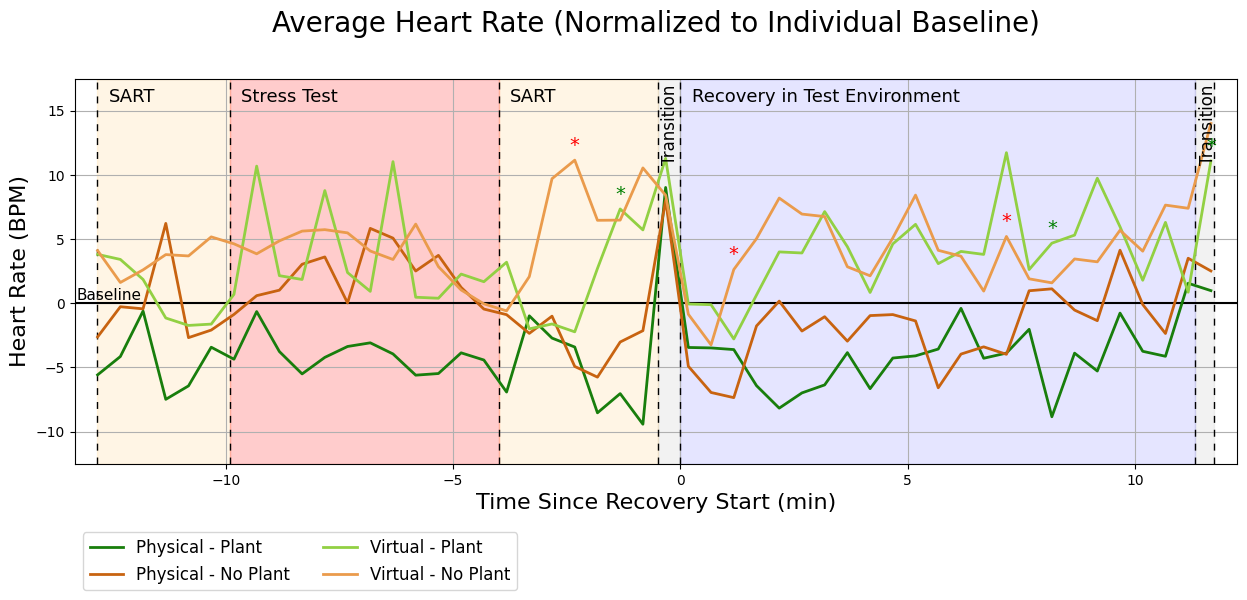

In [49]:
time_bins = bins[:-1] + (bin_size / 2) / 60 # convert to mins

idx = time_bins < 20

# Copy original curves for recovery
avg_plant_p = avg_plant_p[idx]
avg_plant_v = avg_plant_v[idx]
avg_noplant_p = avg_noplant_p[idx]
avg_noplant_v = avg_noplant_v[idx]

plt.figure(figsize=(15, 5))
plt.ylim(-12.5, 17.5)
plt.xlim(-770 / 60 - 0.5, 705 / 60 + 0.5)

selected_font = 'DejaVu Sans'

phases = [
    (-770 / 60, -595 / 60, 'SART', 'orange', 0.1),
    (-595 / 60, -240 / 60, 'Stress Test', 'r', 0.2),
    (-240 / 60, -30 / 60, 'SART', 'orange', 0.1),
    (-30 / 60, 0, 'Transition', 'gray', 0.1),
    (0, 680 / 60, 'Recovery in Test Environment', 'blue', 0.1),
    (680 / 60, 705 / 60, 'Transition', 'gray', 0.1)
]

for start, end, label, color, alpha in phases:
    if start is not None and end is not None:
        plt.axvspan(start, end, color=color, alpha=alpha)
        plt.axvline(x=start, color='black', linestyle=(0, (5, 5)), linewidth=1)
        if label == 'Transition':
            plt.text(start + 0.08, plt.ylim()[1] * 0.975, label, rotation=90,
                     verticalalignment='top', fontsize=12, color='black', family=selected_font)
        else:
            plt.text(start + 0.25, plt.ylim()[1] * 0.96, label, rotation=0,
                     verticalalignment='top', fontsize=13, color='black', family=selected_font)
            
plt.axvline(x=705 / 60, color='black', linestyle=(0, (5, 5)), linewidth=1)
            
plt.axhline(y=0, color='black', linestyle='-')
plt.text(plt.xlim()[0] + 0.05, 0.3, 'Baseline', horizontalalignment='left', fontsize=11, color='black')

colors = [
    ['#187E0C', '#13530C'], # dark green   – physical plants
    ['#C86310', '#A04E0B'], # dark orange  – physical no-plants
    ['#92D043', '#73AF27'], # light green  – virtual plants
    ['#EA9B4C', '#C77420'], # light orange – virtual no-plants
]

# Plot individual recovery lines
plt.plot(time_bins[idx], avg_plant_p, label='Physical - Plant', color=colors[0][0], marker='', 
         markeredgecolor = colors[0][1], markersize = 6.5, linewidth = 2)
plt.plot(time_bins[idx], avg_noplant_p, label='Physical - No Plant', color=colors[1][0], marker='', 
         markeredgecolor = colors[1][1], markersize = 6.5, linewidth = 2)
plt.plot(time_bins[idx], avg_plant_v, label='Virtual - Plant', color=colors[2][0], marker='', 
         markeredgecolor = colors[2][1], markersize = 6.5, linewidth = 2)
plt.plot(time_bins[idx], avg_noplant_v, label='Virtual - No Plant', color=colors[3][0], marker='', 
         markeredgecolor = colors[3][1], markersize = 6.5, linewidth = 2)

# Plot significance stars
for i, (x, sig) in enumerate(zip(time_bins[idx], fdr_significant_plant[idx])):
    if sig:
        y = max(avg_plant_p[i], avg_plant_v[i]) + 0.75
        plt.text(x, y, '*', ha='center', fontsize=14, color='green', label='Plant: p < 0.05')

for i, (x, sig) in enumerate(zip(time_bins[idx], fdr_significant_noplant[idx])):
    if sig:
        y = max(avg_noplant_p[i], avg_noplant_v[i]) + 0.75
        plt.text(x, y, '*', ha='center', fontsize=14, color='red', label='No Plant: p < 0.05')

# Plot average pre-recovery
#plt.plot(time_bins[pre_idx], avg_pre_recovery, label='All Subjects', color='black', marker='o')

# Labels and style
plt.xlabel('Time Since Recovery Start (min)', fontsize=16, family=selected_font)
plt.ylabel('Heart Rate (BPM)', fontsize=16, family=selected_font)
plt.title('Average Heart Rate (Normalized to Individual Baseline)', y=1.1, fontsize=20, family=selected_font)
plt.legend(loc='lower left', bbox_to_anchor=(0, -0.35), prop={'size': 12}, ncol=2)
plt.grid(True)

#plt.tight_layout()
plt.savefig(os.path.join(dir_plots, 'hr_all_conditions3.jpeg'), dpi=200)
plt.show()